In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
from dataset.cxr_dataset import CXRMulitmodalDataset
from models.multimodal_cnn import MultimodalCNN
# from config import *
from utils.transforms import get_train_transform, get_val_transform

In [47]:
test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
img_dir = '/home/common/data_v3'

# padchest testing
# test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/PADCHEST_selected_with_reports.csv'
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_testing'

device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
import os
len(os.listdir(img_dir))

2

In [49]:
def load_model(checkpoint_path, device):
    model = MultimodalCNN()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [50]:
# checkpoint_path= '/home/jupyter-nafisha/X-ray-covariates/main/last_model_unshuffled.pth'
# checkpoint_path= '/home/jupyter-nafisha/X-ray-covariates/main/best_model_unshuffled.pth'    #best
# checkpoint_path= '/home/jupyter-nafisha/X-ray-covariates/main/last_model.pth'
checkpoint_path= '/home/jupyter-nafisha/X-ray-covariates/main/best_model.pth'

model = load_model(checkpoint_path, device)

# Dataset & dataloader
test_dataset = CXRMulitmodalDataset(test_csv, img_dir, transform=get_val_transform())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Ground-truth labels (Normal=0, Abnormal=1)
# true_labels = test_dataset.df["label"].tolist()
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 7,086,753
Trainable parameters: 7,086,753


In [52]:
predictions = []
with torch.no_grad():
    for images, view, sex, label in test_loader:  
        images = images.to(device)
        view = view.to(device)
        sex = sex.to(device)
        label = label.to(device)

        logits = model(images, view, sex)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)  # shape: (B,)
        # probs = torch.sigmoid(logits)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        # predictions.extend(preds.cpu().numpy())
        # print(label, preds)
        predictions.extend(preds.cpu().numpy().tolist())
        # break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7676055..1.7535212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7676055..1.6706711].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5880971..1.7535212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7676055..1.7535212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7676055..1.7535212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7676055..1.7535212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.767605

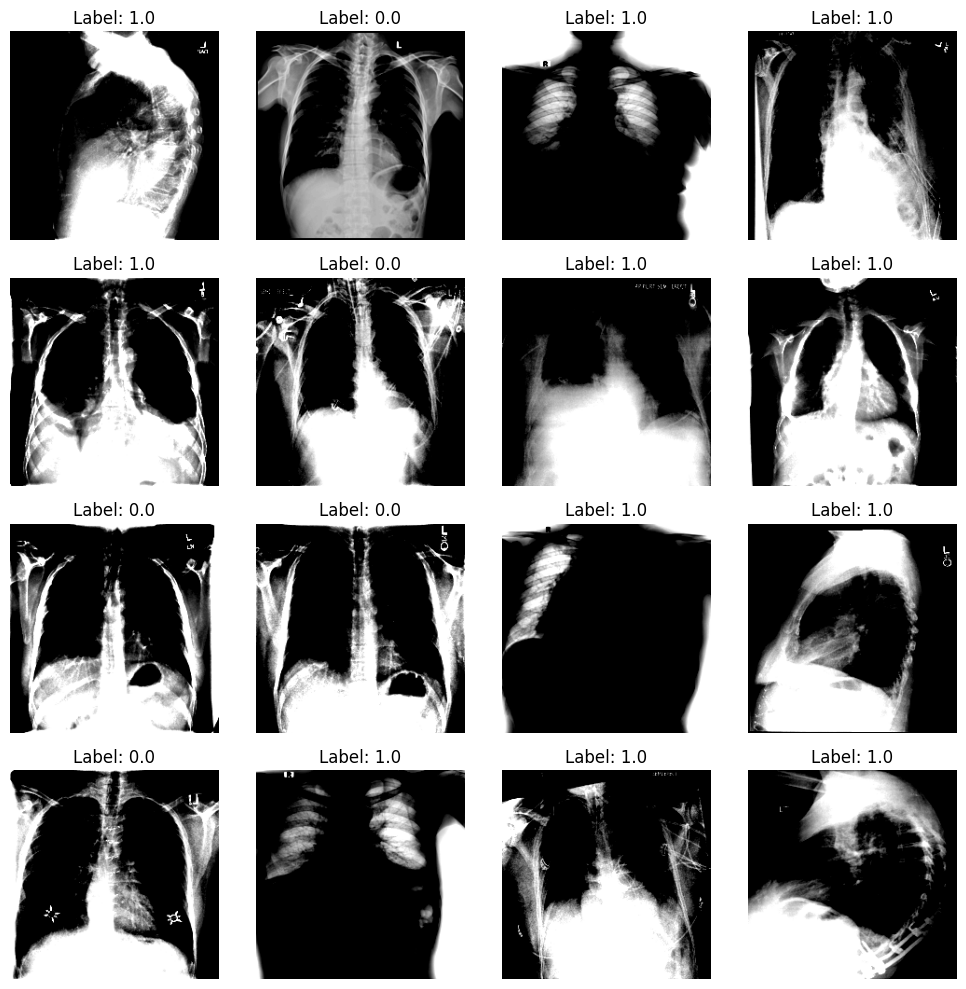

In [53]:
import matplotlib.pyplot as plt
import torch

# Get one batch
for images, view, sex, label in test_loader:
    break  # only take the first batch

# If images are normalized, unnormalize them (optional but common)
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# images = unnormalize(images)

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [54]:
df = pd.DataFrame({
    "image_name": image_names,
    "true_label": true_labels,
    "predicted_label": predictions
})

In [55]:
# df.to_csv("test_predictions_padchest.csv", index=False)

In [56]:
acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

In [57]:
print(f"Accuracy     :  {acc:.4f}")
print(f"Precision    :  {precision:.4f}")
print(f"Recall       :  {recall:.4f}")
print(f"Specificity  :  {specificity:.4f}")
print(f"F1 Score     :  {f1:.4f}")

Accuracy     :  0.8063
Precision    :  0.7952
Recall       :  0.8407
Specificity  :  0.7699
F1 Score     :  0.8173


In [58]:
cm

array([[2673,  799],
       [ 588, 3102]])

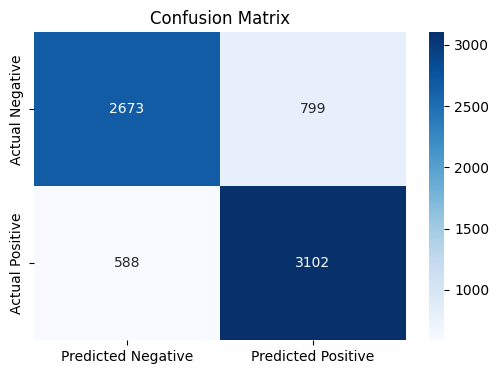

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()

### Result Analysis

In [14]:
act_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
pred_csv = '/home/jupyter-nafisha/X-ray-covariates/main/test_predictions.csv'

In [15]:
import pandas as pd
act_data = pd.read_csv(act_csv)
pred_data = pd.read_csv(pred_csv)

In [16]:
act_data

,image_id,sex,class_name,label,orientation
0,chexpert/patient20327/study1/view2_lateral.jpg,M,"Lung Opacity, Lung Lesion, Atelectasis, Pleura...",Abnormal,lateral
1,vinbig/a8e2f097cccbf9fd65c69988fe0dd180.jpg,M,No finding,Normal,PA
2,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,F,"Aortic enlargement, Cardiomegaly, Pleural thic...",Abnormal,PA
3,chexpert/patient41165/study9/view1_frontal.jpg,M,"Lung Opacity, Pleural Effusion",Abnormal,AP
4,chexpert/patient16357/study1/view1_frontal.jpg,M,"Cardiomegaly, Lung Opacity, Lung Lesion, Pleur...",Abnormal,PA
...,...,...,...,...,...
7157,chexpert/patient33278/study1/view1_frontal.jpg,M,Atelectasis,Abnormal,AP
7158,chexpert/patient28207/study9/view2_lateral.jpg,M,"Cardiomegaly, Lung Opacity, Pleural Effusion",Abnormal,lateral
7159,chexpert/patient30795/study2/view2_lateral.jpg,M,Lung Opacity,Abnormal,lateral
7160,chexpert/patient31499/study3/view1_frontal.jpg,F,No Finding,Normal,PA


In [17]:
pred_data

,image_name,true_label,predicted_label
0,chexpert/patient20327/study1/view2_lateral.jpg,1,1
1,vinbig/a8e2f097cccbf9fd65c69988fe0dd180.jpg,0,0
2,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,1,1
3,chexpert/patient41165/study9/view1_frontal.jpg,1,1
4,chexpert/patient16357/study1/view1_frontal.jpg,1,1
...,...,...,...
7157,chexpert/patient33278/study1/view1_frontal.jpg,1,1
7158,chexpert/patient28207/study9/view2_lateral.jpg,1,1
7159,chexpert/patient30795/study2/view2_lateral.jpg,1,1
7160,chexpert/patient31499/study3/view1_frontal.jpg,0,1


In [18]:
merged_df= act_data.merge(
    pred_data,
    left_on = 'image_id', 
    right_on = 'image_name',
    how= 'inner'
)

In [20]:
merged_df

,image_id,sex,class_name,label,orientation,image_name,true_label,predicted_label
0,chexpert/patient20327/study1/view2_lateral.jpg,M,"Lung Opacity, Lung Lesion, Atelectasis, Pleura...",Abnormal,lateral,chexpert/patient20327/study1/view2_lateral.jpg,1,1
1,vinbig/a8e2f097cccbf9fd65c69988fe0dd180.jpg,M,No finding,Normal,PA,vinbig/a8e2f097cccbf9fd65c69988fe0dd180.jpg,0,0
2,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,F,"Aortic enlargement, Cardiomegaly, Pleural thic...",Abnormal,PA,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,1,1
3,chexpert/patient41165/study9/view1_frontal.jpg,M,"Lung Opacity, Pleural Effusion",Abnormal,AP,chexpert/patient41165/study9/view1_frontal.jpg,1,1
4,chexpert/patient16357/study1/view1_frontal.jpg,M,"Cardiomegaly, Lung Opacity, Lung Lesion, Pleur...",Abnormal,PA,chexpert/patient16357/study1/view1_frontal.jpg,1,1
...,...,...,...,...,...,...,...,...
7157,chexpert/patient33278/study1/view1_frontal.jpg,M,Atelectasis,Abnormal,AP,chexpert/patient33278/study1/view1_frontal.jpg,1,1
7158,chexpert/patient28207/study9/view2_lateral.jpg,M,"Cardiomegaly, Lung Opacity, Pleural Effusion",Abnormal,lateral,chexpert/patient28207/study9/view2_lateral.jpg,1,1
7159,chexpert/patient30795/study2/view2_lateral.jpg,M,Lung Opacity,Abnormal,lateral,chexpert/patient30795/study2/view2_lateral.jpg,1,1
7160,chexpert/patient31499/study3/view1_frontal.jpg,F,No Finding,Normal,PA,chexpert/patient31499/study3/view1_frontal.jpg,0,1


In [53]:
female_data = merged_df[merged_df['sex']=='F']
male_data = merged_df[merged_df['sex']=='M']

lateral_data = merged_df[merged_df['orientation']=='lateral']
PA_data = merged_df[merged_df['orientation']=='PA']
AP_data = merged_df[merged_df['orientation']=='AP']

vinbig_data = merged_df[merged_df['image_id'].str.startswith('vinbig')]
chexpert_data = merged_df[merged_df['image_id'].str.startswith('chexpert')]

In [26]:
# len(vinbig_data), len(chexpert_data)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

true_labels = vinbig_data['label'].map({"Normal": 0, "Abnormal": 1}).tolist()
predictions = vinbig_data['predicted_label']

acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

print("\n==== Evaluation Metrics ====")
print(f"Accuracy     :  {acc:.4f}")
print(f"Precision    :  {precision:.4f}")
print(f"Recall       :  {recall:.4f}")
print(f"Specificity  :  {specificity:.4f}")
print(f"F1 Score     :  {f1:.4f}")


==== Evaluation Metrics ====
Accuracy     :  0.9289
Precision    :  0.9364
Recall       :  0.9208
Specificity  :  0.9371
F1 Score     :  0.9286


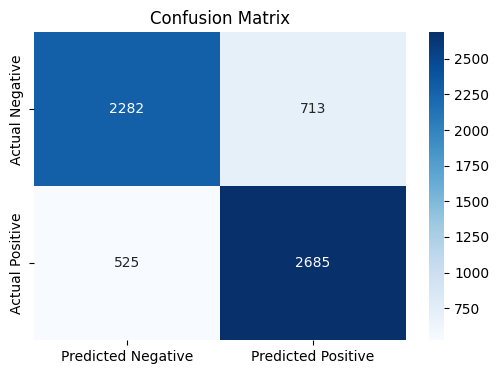

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()

In [45]:
type(predictions[0])

int

In [17]:
import torch
import torch.nn as nn
from torchvision import models
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [19]:
x= torch.rand(1, 1, 224, 224)
out = model(x)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [27]:
import pandas as pd
csv_path = 'test_predictions_padchest.csv'
data = pd.read_csv(csv_path)

In [29]:
mismatch = data[data['true_label']!= data['predicted_label']]

In [30]:
mismatch

,image_name,true_label,predicted_label
0,20536686640136348236148679891455886468_k6ga29.png,0,1
14,200091420165336548849526592472869689994_n0exds...,1,0
23,246171875935311699934475428004488908204_2u8xw0...,1,0
26,92479534840024514330951523511120923900_5xls6f.png,1,0
33,240901793831868002350241513124822033145_clgbhs...,1,0
...,...,...,...
1563,94136626146558444966681004736205767133-2_etc0s...,1,0
1570,1059090736492172890440690893294928964_qnu89a.png,1,0
1571,1059090736492172890440690893294928964_qnqec4.png,1,0
1572,110197446456814343356996631403599875033_zo9oo6...,1,0


In [31]:
FP = mismatch[mismatch['predicted_label']==1]
FN = mismatch[mismatch['predicted_label']==0]

In [35]:
FN.iloc[0:50]

,image_name,true_label,predicted_label
14,200091420165336548849526592472869689994_n0exds...,1,0
23,246171875935311699934475428004488908204_2u8xw0...,1,0
26,92479534840024514330951523511120923900_5xls6f.png,1,0
33,240901793831868002350241513124822033145_clgbhs...,1,0
34,240901793831868002350241513124822033145_bnzkfq...,1,0
38,62251368659414281768550499840080640229_8mln0w.png,1,0
41,47784381729225956156725553701446715500_sgkre8.png,1,0
46,2131660293658241410166268879399943517_h0uqds.png,1,0
50,67670115219232152220849057375830836196_8lyy43.png,1,0
51,303749711587233420279581812693876233202_comg8i...,1,0
